In [1]:
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
import xgboost as xgb
MAX_TOWERS = 6
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import random

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error
from scipy.sparse import hstack 
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import math

/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from utils import get_test, get_train
from pipelines import common_pipeline, train_hook, target_hook, \
    cont_pipeline, cat_pipeline, null_cat_step, text_pipeline, date_pipeline
from cleaner import DataCleaner

dc = DataCleaner(common_pipelines=common_pipeline, column_pipelines=[
    cont_pipeline, null_cat_step, cat_pipeline, text_pipeline, date_pipeline],
                 train_hooks=train_hook, target_hooks=target_hook)

X_train, X_test, y_train, groups = dc.get_clean_data(get_train(), get_test(), group_col="Скважина")

after hooks
(8975, 153)
(412, 144)
Нефть, т dropped
{'Примечание', 'Агент закачки', 'Фирма ГРП', 'Тип газосепаратора', 'Станок-качалка'} dropped
['Жидкость, м3', 'ТП(ИДН) Дебит жидкости', 'ТП(ГРП) Дебит жидкости скорр-ый', 'ТП(ГРП) Дебит жидкости', 'ТП(ИДН) Дебит жидкости скорр-ый', 'Нефть, м3', 'ГП - Общий прирост Qн', 'Дебит жидкости'] dropped
After common_pipeline
(8975, 139)
(412, 139)


/Users/kkushaev/PycharmProjects/gp_oil/src/pipelines.py:366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[c] = train[c].astype(str)
/Users/kkushaev/PycharmProjects/gp_oil/src/pipelines.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test[c] = test[c].astype(str)
/Users/kkushaev/PycharmProjects/gp_oil/src/pipelines.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

nans in column pipelines
False
shape_after_column_pipelines
(8975, 883)
(412, 883)


In [3]:
from utils import clean_non_targeted
X_train, groups, y_train = clean_non_targeted([X_train, groups], y_train)

(7115, 883)
(7115,)
(7115,)


In [22]:
def get_fold():
    return KFold(n_splits = 4,shuffle=True, random_state = 17)

In [12]:
def get_preds_for_cats(train, test, y, cat_features):
    print("start catboost")
    cb_regressor = CatBoostRegressor(logging_level="Silent", random_state=17)
    train_catboost_preds = cross_val_predict(cb_regressor, train, y)
    cb_regressor.fit(train,y=y, cat_features=cat_features)
    test_catboost_preds = pd.Series(cb_regressor.predict(test), index=test.index)
    print("finish catboost")
    return train_catboost_preds, test_catboost_preds

In [13]:
def get_cont_ensemble():
    print("start ensemble")
    ridge = Ridge(random_state=17)
    rtree = RandomForestRegressor(n_jobs=-1, n_estimators=150, random_state=17)
    svr = LinearSVR(random_state=17)
    xgboost = xgb.XGBRegressor(n_estimators=200, max_depth=5, random_state=17, n_jobs=-1)
    nn = MLPRegressor(max_iter=500, random_state=17)
    et = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, random_state=17)
    lasso = Lasso(random_state=17)
    return [lasso, rtree, xgboost]

def get_cont_ensemble_names():
    return ["lasso", "rtree", "xgboost"]

In [14]:
def get_meta_train_preds(X, y, ):
    predicts = []
    for cl in get_cont_ensemble():
        predicts.append(cross_val_predict(cl, X,y, n_jobs=-1, cv=get_fold()))
    return pd.DataFrame(np.vstack(predicts).transpose(), index=y.index, columns=get_cont_ensemble_names())

def get_meta_test_predict(X_train, y_train, X_test):
    test_predicts = []
    
    for i,cl in enumerate(get_cont_ensemble()):
        print("%s:%s"%(i,cross_val_score(cl, X_train, y_train, n_jobs=-1, scoring="neg_mean_absolute_error", cv=get_fold())))
        cl.fit(X_train, y_train)
        pr = cl.predict(X_test)
        test_predicts.append(pr)
    #add svd predicts
    return  pd.DataFrame(np.vstack(test_predicts).transpose(), index=X_test.index, columns=get_cont_ensemble_names())

def get_stacked_ensemble_predict(X_meta, y, X_test):
    regressor = xgb.XGBRegressor(random_state=17, n_jobs=-1)
    regressor.fit(X_meta, y)
    return pd.DataFrame(regressor.predict(X_test), index=X_test.index)

In [15]:
def get_n_item_index(group_size, df, group):
    new_df = pd.concat([df, group], axis = 1)
    index = []
    group = new_df.groupby(["Скважина"])
    for name, group in group:
        if len(group)<group_size:
            continue
        for start in range(len(group.index) - group_size):
            gr =group.index[start:start+group_size]
            index.append(gr)
    return index

def get_timed_ds(meta_size, df, group, y):
    if meta_size >= 1:
        meta_indexes = get_n_item_index(meta_size, df, group)
        first_value_idx = []
        timed_ds = df.copy()
        metas = []
        columns = []
        for i in range(meta_size):
            columns.append("meta%s"%str(i))
        for a in meta_indexes:
            first_value_idx.append(a[0])
            metas.append(list(y.loc[a]))
        metas_df = pd.DataFrame.from_records(metas, index=first_value_idx, columns=columns)
        return pd.concat([timed_ds.loc[first_value_idx], metas_df], axis=1)
    elif meta_size == 0:
        return df
    
def get_n_tower_predictions(n, train, y, test, train_group):
    X_meta_train = get_meta_train_preds(train, y)
    X_meta_test = get_meta_test_predict(train, y, test)
    test_predictions= []
    for i in range(0,n):
        train_timed_ds = get_timed_ds(i,X_meta_train, train_group, y)
        y_timed = y.loc[train_timed_ds.index]
        test_predict = get_stacked_ensemble_predict(train_timed_ds, y_timed,X_meta_test)
        test_predictions.append(test_predict)
        X_meta_test["meta%s"%i]=test_predict
    return pd.concat(test_predictions,axis=1)

In [16]:
def create_submission(fname, df):
    final_pred = pd.Series(df)
    final_pred.to_csv(fname,header=["_VAL_"],index_label=["_ID_"])

In [23]:
get_prediction(X_train, X_test,groups, y_train)

start ensemble


/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

start ensemble


/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

0:[-112.91058947 -115.10910131 -122.01581689 -117.5734522 ]


/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


1:[-17.82438182 -15.41087173 -20.27349871 -19.72727548]
2:[-26.89115933 -26.16703207 -28.12583985 -28.92121573]


array([693.139  , 685.6526 , 700.13654, ..., 683.0149 , 685.7438 ,
       682.89087], dtype=float32)

In [20]:
def transform_target(target):
    return target

def get_prediction(train_cont, test_cont, train_group, y_train, constant = 701.4750):
    np.random.seed(17)
    random.seed(17)
    y_train = transform_target(y_train)
    time_serie_pred = get_n_tower_predictions(
        6, train_cont, y_train,test_cont, train_group
    ).values.reshape(-1,1)
    time_serie_pred = np.squeeze(time_serie_pred)
    delta = constant - np.mean(time_serie_pred)
    final_pred = time_serie_pred+delta
    return final_pred

In [378]:
X_train, Y, X_test, group, order = get_clean_data(get_train(), get_test(), cut=False)

{'Примечание', 'Агент закачки', 'Фирма ГРП', 'Станок-качалка', 'Тип газосепаратора'} dropped
Нефть, т dropped
['ТП(ГРП) Дебит жидкости', 'Дебит жидкости', 'Нефть, м3', 'Жидкость, м3', 'ГП - Общий прирост Qн', 'ТП(ИДН) Дебит жидкости', 'ТП(ГРП) Дебит жидкости скорр-ый', 'ТП(ИДН) Дебит жидкости скорр-ый'] dropped
(8975, 139)
(412, 139)
False
False


In [226]:
create_submission("all_data_log_linear_corrected.csv", preds_final)

In [379]:
X_train.shape

(8975, 883)

In [380]:
X_test.shape

(412, 883)

In [381]:
from sklearn.metrics.pairwise import cosine_similarity
def get_most_similar(x1,x2):
    matr = cosine_similarity(x1,x2)
    return np.argmax(matr, axis = 0)

similar_to_test  = get_most_similar(X_train,X_test)
similar_to_test

array([ 935, 3556, 1145, 2288, 8105, 8106,  893,  893, 6388, 4998, 8159,
       6303, 4854, 4472, 3457, 8159, 4125, 3667, 1161, 3596, 8159, 4728,
       4728, 3310, 3310, 6894, 4664, 7538, 3271, 3272, 6894, 3392, 2260,
       4998, 5550, 4854, 4854, 3170, 8687, 6388, 3383, 3383, 1173, 2918,
       3577, 4394, 3554, 6119, 3805, 3805, 1229, 1230, 4397, 3595, 4397,
       2690, 4362, 6390, 1550, 1550, 1550, 1550, 1551, 1551, 1551, 1551,
       7226, 7226, 5154, 3793, 8651, 2618, 3596, 1251, 4854,  629, 6422,
       6279, 1147, 3170, 3383, 2132, 4123, 4124, 4125, 1145, 5172, 5154,
       8687, 6939, 5963, 2132, 2288, 5694, 5695, 5696, 5697, 7879, 4728,
       4728, 1891, 1391, 7538,  300,  300, 7130, 4125, 4125, 2691, 5000,
       3170, 1145, 2216, 5026, 5154, 5000, 5000,  581, 3595, 7685, 6388,
       6388, 3691, 7957, 4746, 4746,  221, 6939, 3383, 8159,  935, 1389,
       8651, 6388, 4394, 3457, 3457, 1121, 1121, 1121, 5526, 6279, 4728,
       3595, 6387, 6881, 6881, 6881, 7681, 2438, 56

In [382]:
target_group = group.loc[similar_to_test]
target_group = target_groups.values.ravel()
test_sim_idx = group[group.isin(target_group).values]

In [383]:
true_test = pd.concat([X_train.loc[test_sim_idx.index]], axis=1)

/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [387]:
X_sim_test,y_sim_test,constant = get_cleaned_test(true_test)

Нефть, т dropped
(452, 884)
(452,)


In [388]:
true_test.shape

(2108, 885)

In [362]:
X_sim_test.shape

(39, 884)

In [373]:
X_sim_train = X_train.drop(index=true_test.index)
y_sim_train = Y.drop(index=true_test.index)

In [153]:
def get_cleaned_test(test, size=6):
    test, y_test = get_target(test)
    test, y_test = clean_non_targeted([test], y_test)
    X_idx = []
    y_idx = []
    group = test.groupby(["Скважина"])
    for name, group in group:
        if len(group)!= size:
            continue
        X_idx.append(group.index[0])
        y_idx.extend(group.index)
    if X_idx and y_idx:
        test = test.loc[X_idx]
        y_test = y_test[y_idx]
        y_test = transform_target(y_test)
        constant = np.mean(y_test.values)
        return test, y_test, constant
    else:
        return None, None, None

In [154]:
def cross_validate(train, n_folds = 4):
    errors = []
    k_fold = KFold(n_splits=n_folds, random_state=17, shuffle=True)
    for tr_ix, test_ix in k_fold.split(train):
        print("new fold started")
        train_cv = train.iloc[tr_ix]
        test_cv = train.iloc[test_ix]
        test_cv, y_test, constant = get_cleaned_test(test_cv)
        test_preds = get_prediction(train_cv, test_cv, constant=constant)
        error=mean_absolute_error(y_true=y_test, y_pred=test_preds)
        print("fold error:%s" % error)
        errors.append(error)
    print("overall error: %s" % np.mean(errors))
    print(errors)

In [157]:
cross_validate(get_train())

new fold started
Нефть, т dropped
(1767, 152)
(1767,)


/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Причина простоя.1', 'Тип дополнительного оборудования', 'Примечание', 'Мероприятия', 'Агент закачки', 'Фирма ГРП', 'Станок-качалка', 'Тип газосепаратора', 'Тип скважины', 'Марка ПЭД', 'КНС'} dropped
Нефть, т dropped
[] dropped
(6731, 141)
(21, 141)
False
False
(2032, 822)
(2032, 1)
(2032, 22)
(2032,)
start ensemble
start ensemble
0:[-5.26750854 -4.83628815 -5.44675178 -5.61317239]
1:[-4.33734318 -5.41715682 -9.47807375 -4.81749278]
2:[-3.19747215 -4.08130162 -6.49122146 -3.92387238]
fold error:318.788289397709
new fold started
Нефть, т dropped
(1771, 152)
(1771,)


/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Ток рабочий', 'Дата запуска после КРС', 'Динамическая высота', 'Удельный коэффициент', 'Мероприятия', 'Тип насоса', 'Тип ГЗУ', 'Диаметр дополнительного оборудования', 'Станок-качалка', 'Пласт МЭР', 'объемный коэффициент', 'Дата ввода в эксплуатацию', 'SKIN', 'ГП(ИДН) Дебит жидкости', 'ТП - SKIN', 'КНС', 'Характеристический дебит жидкости', 'Глубина верхних дыр перфорации', 'Длина хода плунжера ШГН', 'Глубина спуска', 'Температура пласта', 'Фонтан через насос', 'ГП(ГРП) Дебит жидкости скорр-ый', 'Давление на приеме', 'Напор', 'Мощность ПЭД', 'Способ эксплуатации', 'ДНС', 'ТП(ИДН) Дебит жидкости скорр-ый', 'Диаметр НКТ', 'Удлинение', 'Диаметр плунжера', 'Вязкость нефти в пластовых условиях', 'I X/X', 'Дата пуска', 'Тип газосепаратора', 'Высота перфорации', 'Неустановившийся режим', 'JD факт', 'Номер бригады', 'Глубина спуска доп. оборудования', 'ТП(ГРП) Дебит жидкости скорр-ый', 'Причина простоя.1', 'Состояние на конец месяца', 'Производительность ЭЦН', 'Газовый фактор', 'КН закрепленн

/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Причина простоя.1', 'Тип дополнительного оборудования', 'Примечание', 'Мероприятия', 'Агент закачки', 'Фирма ГРП', 'Станок-качалка', 'Тип газосепаратора', 'Дата ГРП', 'Марка ПЭД', 'КНС'} dropped
Нефть, т dropped
[] dropped
(6731, 141)
(19, 141)
False
False
(1982, 818)
(1982, 1)
(1982, 23)
(1982,)
start ensemble
start ensemble
0:[-5.08773347 -5.15452572 -5.30366483 -5.61329658]
1:[-4.36949906 -4.34746183 -7.24693657 -9.16310249]
2:[-3.1495162  -3.59596181 -6.98730615 -5.93493193]
fold error:275.3102597206517
new fold started
Нефть, т dropped
(1788, 152)
(1788,)


/anaconda2/envs/env/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


{'Ток рабочий', 'Дата запуска после КРС', 'Динамическая высота', 'Удельный коэффициент', 'Мероприятия', 'Тип насоса', 'Тип ГЗУ', 'Диаметр дополнительного оборудования', 'Станок-качалка', 'Пласт МЭР', 'объемный коэффициент', 'Дата ввода в эксплуатацию', 'SKIN', 'ГП(ИДН) Дебит жидкости', 'ТП - SKIN', 'КНС', 'Характеристический дебит жидкости', 'Глубина верхних дыр перфорации', 'Длина хода плунжера ШГН', 'Глубина спуска', 'Температура пласта', 'Фонтан через насос', 'ГП(ГРП) Дебит жидкости скорр-ый', 'Давление на приеме', 'Напор', 'Мощность ПЭД', 'Способ эксплуатации', 'ДНС', 'ТП(ИДН) Дебит жидкости скорр-ый', 'Диаметр НКТ', 'Удлинение', 'Диаметр плунжера', 'Вязкость нефти в пластовых условиях', 'I X/X', 'Дата пуска', 'Тип газосепаратора', 'Высота перфорации', 'Неустановившийся режим', 'JD факт', 'Номер бригады', 'Глубина спуска доп. оборудования', 'ТП(ГРП) Дебит жидкости скорр-ый', 'Причина простоя.1', 'Состояние на конец месяца', 'Производительность ЭЦН', 'Газовый фактор', 'КН закрепленн

In [27]:
299.720573012412
[289.9811313784219, 335.9357574203388, 126.81710257918746, 446.1483006716997]
300.25068988386926
[290.65788832253554, 336.1340891623984, 127.1327437987151, 447.07803825182793]
300.18614828409784
[290.4273996641578, 335.9788732308109, 127.15651752895779, 447.18180271246496]
285.9852514405545
[267.45969725620597, 281.4598397521973, 81.43385848363239, 513.5876102701824]
260.7050305503842
[285.48734338760374, 240.13236792105218, 238.9836193061597, 226.74571254057042, 312.176109596535]
294.66398402441115
[240.20572041829428, 346.64098253522604, 298.8145652553014, 292.994667888823]
295.00947591811894
[240.35139353434244, 347.16105438232427, 298.9804015289791, 293.54505422682985]
295.90190843312
[241.25445229554788, 348.402697652181, 299.64674013168093, 294.30374365307034]
295.3792892683586
[241.22872128217648, 347.65355759393606, 299.4774894011967, 293.15738879612513]
295.1825753026131
[241.04178057548327, 346.85150514148535, 299.4132816278367, 293.4237338656471]
294.9022548526955
[241.1999166009365, 345.8461416771299, 299.4364936368428, 293.1264674958728]
293.59822052331515
[240.6871044182667, 345.6373588043017, 298.5003662020143, 289.5680526686779]
295.0485831301902
[242.15174558199368, 345.12844017392115, 299.55880542573476, 293.3553413391113]
295.3146868490794
[241.1199405924479, 347.18048281715033, 299.70953150189115, 293.2487924848284]
295.39453709307753
[242.4517316143329, 345.3109058634441, 299.8078347972083, 294.0076760973249]
295.9224823257018
[242.46150878123748, 346.54313555036276, 300.30083731030663, 294.38444766090026]
315.52536334941624
[318.788289397709, 239.65920534076108, 275.3102597206517, 428.3436989385431]


#logarithmic
0.8513609468749455
[1.3160352156536677, 0.46891223857426984, 0.9269136348798445, 0.693582698392]

[290.4273996641578, 335.9788732308109, 127.15651752895779, 447.18180271246496]

In [167]:
X_train, y_train, X_test, group = get_clean_data(get_train(),get_test())

{'Примечание', 'Агент закачки', 'Фирма ГРП', 'Станок-качалка', 'Тип газосепаратора'} dropped
Нефть, т dropped
['ТП(ГРП) Дебит жидкости', 'Дебит жидкости', 'Нефть, м3', 'Жидкость, м3', 'ГП - Общий прирост Qн', 'ТП(ИДН) Дебит жидкости', 'ТП(ГРП) Дебит жидкости скорр-ый', 'ТП(ИДН) Дебит жидкости скорр-ый'] dropped
(8975, 139)
(412, 139)
False
False
(2201, 883)
(2201, 1)
(2201, 28)
(2201,)


/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

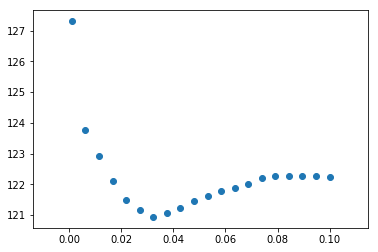

In [179]:

scores =[]
for a in np.linspace(0.001, 0.1, 20):
    scores.append(np.mean(-cross_val_score(Lasso(alpha=a),X_train, y_train, n_jobs=-1, 
                                   scoring="neg_mean_absolute_error", cv=get_fold())))
plt.scatter(np.linspace(0.001, 0.1, 20),scores)

In [185]:
from sklearn.grid_search import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [500, 700, 1000], 'max_depth': [None, 1, 2, 3], 'min_samples_split': [2, 3, 4]}

# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)
print(clf.best_estimator_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 19.7min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda2/envs/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

CPU times: user 3.5 s, sys: 1.63 s, total: 5.13 s
Wall time: 34.3 s


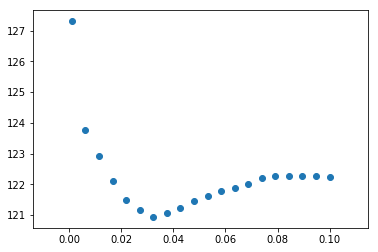

In [190]:
%%time
scores =[]
for a in np.linspace(0.001, 0.1, 20):
    scores.append(np.mean(-cross_val_score(Lasso(alpha=a),np.ascontiguousarray(X_train.values), np.ascontiguousarray(y_train.values), n_jobs=-1, 
                                   scoring="neg_mean_absolute_error", cv=get_fold())))
plt.scatter(np.linspace(0.001, 0.1, 20),scores)